In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
import sys
import os
import random

path = os.path.dirname(os.getcwd())
sys.path.append(path)

from PIL import Image

import numpy as np
from torchvision import transforms


from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import torch
import pandas as pd
from models.models import BaselineModel, IngrPredModel, MultimodalPredictionNetwork

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Instantiate the model
num_ingr = 199
model_backbone = "resnet"
pretrained = False

bert_embeddings = torch.load(f'../utils/data/ingredient_embeddings_bert.pt', map_location=device, weights_only=True)
gat_embeddings = torch.load(f'../utils/data/ingredient_embeddings_gnn_gat.pt', map_location=device, weights_only=True)

baseline_model = BaselineModel(num_ingr=num_ingr).to(device)
bb_lstm_model = IngrPredModel(num_ingr, model_backbone, pretrained).to(device)
multimodal_model = MultimodalPredictionNetwork(num_ingr, model_backbone, bert_embeddings, pretrained, hidden_dim = 512).to(device)
gnn_multimodal_model = MultimodalPredictionNetwork(num_ingr, model_backbone, gat_embeddings, pretrained, hidden_dim = 512).to(device)

baseline_model.load_state_dict(torch.load("../models/checkpoints/baseline_cnn_mlp_False_False_True_16_100_norelu.pth", map_location=device, weights_only=True))
bb_lstm_model.load_state_dict(torch.load("../models/checkpoints/bb_lstm_resnet_pretrain_da_16_100.pth", map_location=device, weights_only=True))
multimodal_model.load_state_dict(torch.load("../models/checkpoints/multimodal_resnet_pretrained_da_16_75_25.pth", map_location=device, weights_only=True))
gnn_multimodal_model.load_state_dict(torch.load("../models/checkpoints/multimodal_resnet_gat_pretrained_da_16_75_25.pth", map_location=device, weights_only=True))

<All keys matched successfully>

In [3]:
# Ensure the models are in evaluation mode
baseline_model.eval()
bb_lstm_model.eval()
multimodal_model.eval()
gnn_multimodal_model.eval()

print("Models loaded")

Models loaded


In [4]:
# Select the target convolutional layers for Grad-CAM
baseline_target_layer = [baseline_model.conv5]
bb_lstm_target_layer = [bb_lstm_model.backbone.backbone.layer4[-1].conv3]  # ResNet
multimodal_target_layer = [multimodal_model.image_extractor.backbone.backbone.layer4[-1].conv3]  # ResNet
gnn_multimodal_target_layer = [gnn_multimodal_model.image_extractor.backbone.backbone.layer4[-1].conv3]  # ResNet

In [5]:
### Data Paths ###
dataset_path = '../../data/nutrition5k_reconstructed/'

image_path = os.path.join(dataset_path, 'images')
ingr_mata = os.path.join(dataset_path, 'metadata/ingredients_metadata.csv')

# Load the ingredient metadata
ingr_dataset_path = '../utils/data/test_labels_ingr_log.csv'
ingr_meta_df = pd.read_csv(ingr_mata)
ingr_df = pd.read_csv(ingr_dataset_path)

test_image_ids = ingr_df['id'].tolist()
# randomly sample 8 images
random.seed(333)
sampled_images = random.sample(test_image_ids, 8)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

transformed_images = []
input_images = []
ingr_index = []
highest_ingr_name = []
highest_ingr_value = []

for image_id in sampled_images:
    # Prepare input image (e.g., a single image from a dataset)
    image_to_explain = f"../../data/nutrition5k_reconstructed/images/{image_id}.jpeg"
    
    image = Image.open(image_to_explain).convert('RGB')
    # Apply the transformations needed
    transformed_image = transform(image)
    input_image = transform_normalize(transformed_image)
    
    transformed_images.append(transformed_image)
    input_images.append(input_image)
    
    # Get the row for the dish
    dish_row = ingr_df[ingr_df['id'] == image_id]
    # Get all indices with ingredients > 0 for the dish
    dish_row = dish_row.drop(columns=['id', 'img_indx'])

    # Find the ingredient with the highest value
    highest_ingr = dish_row.iloc[0].idxmax()    # Ingredient with the highest value
    highest_value = dish_row.iloc[0].max()    # Maximum value in the row
    highest_ingr_index = dish_row.columns.get_loc(highest_ingr)
    
    ingr_index.append(highest_ingr_index)
    highest_ingr_name.append(highest_ingr)
    highest_ingr_value.append(highest_value)


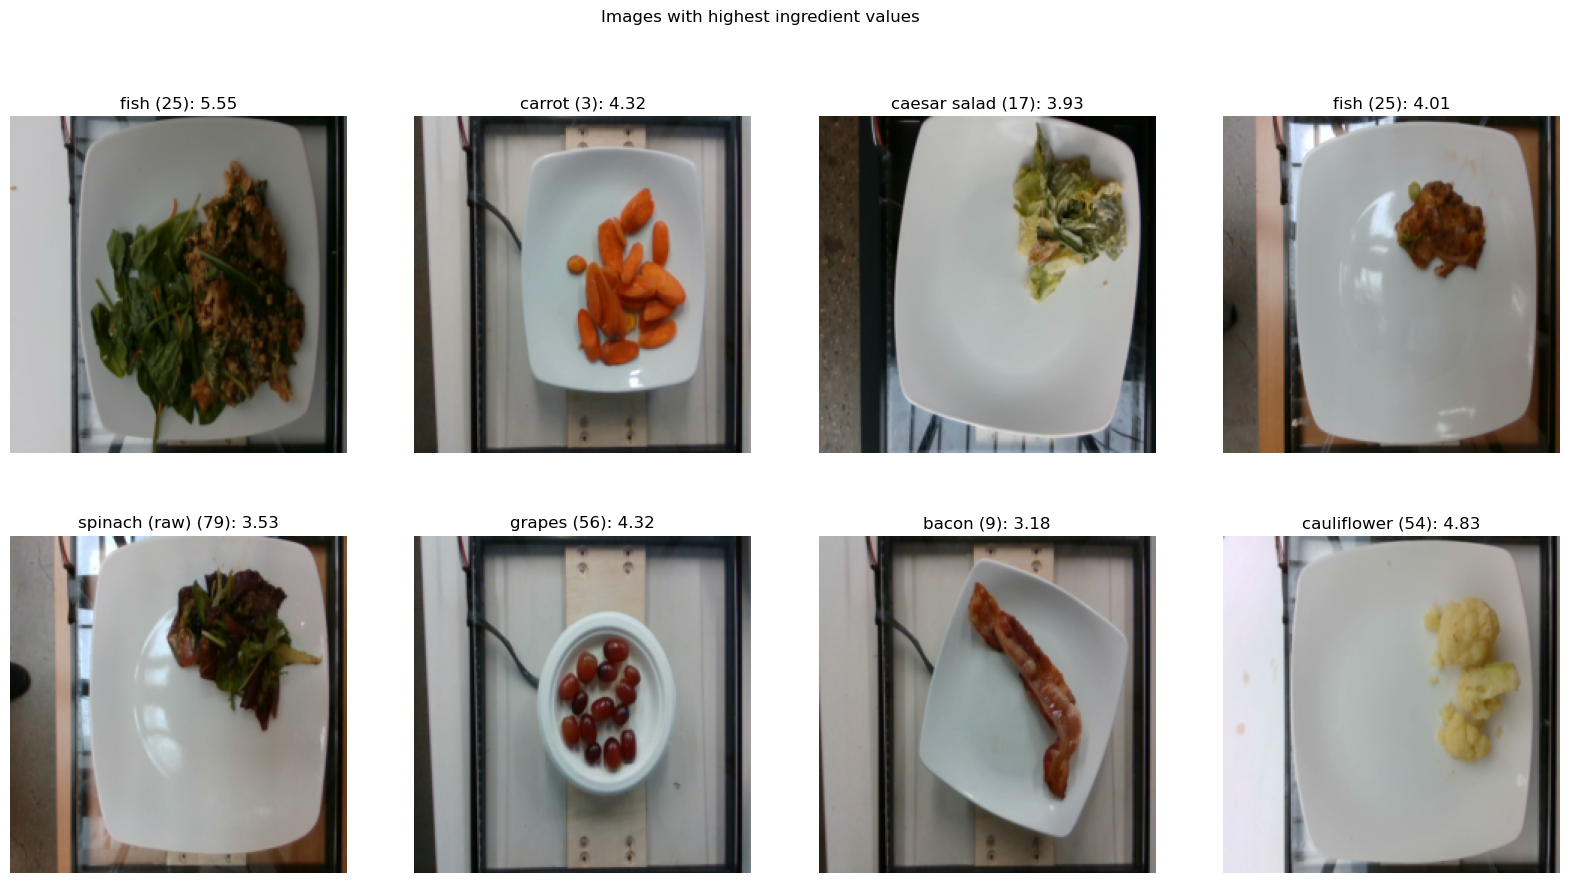

In [6]:
##### Visualize the images And Data #####
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Images with highest ingredient values')

for i, ax in enumerate(axs.flat):
    ax.imshow(transformed_images[i].permute(1, 2, 0))
    ax.set_title(f"{highest_ingr_name[i]} ({ingr_index[i]}): {highest_ingr_value[i]:.2f}")
    ax.axis('off')
plt.show()

In [7]:
# Instantiate Grad-CAMs
baseline_cam = GradCAM(model=baseline_model, target_layers=baseline_target_layer)
bb_lstm_cam = GradCAM(model=bb_lstm_model, target_layers=bb_lstm_target_layer)
multimodal_cam = GradCAM(model=multimodal_model, target_layers=multimodal_target_layer)
gnn_multimodal_cam = GradCAM(model=gnn_multimodal_model, target_layers=gnn_multimodal_target_layer)


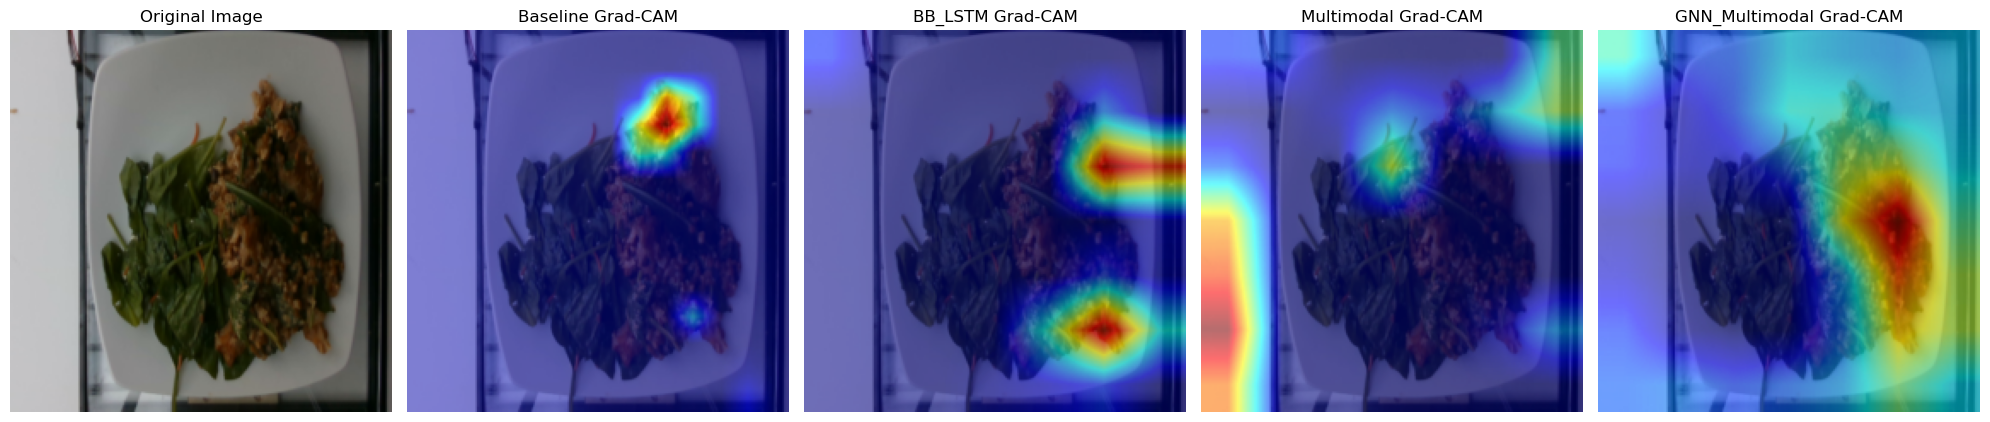

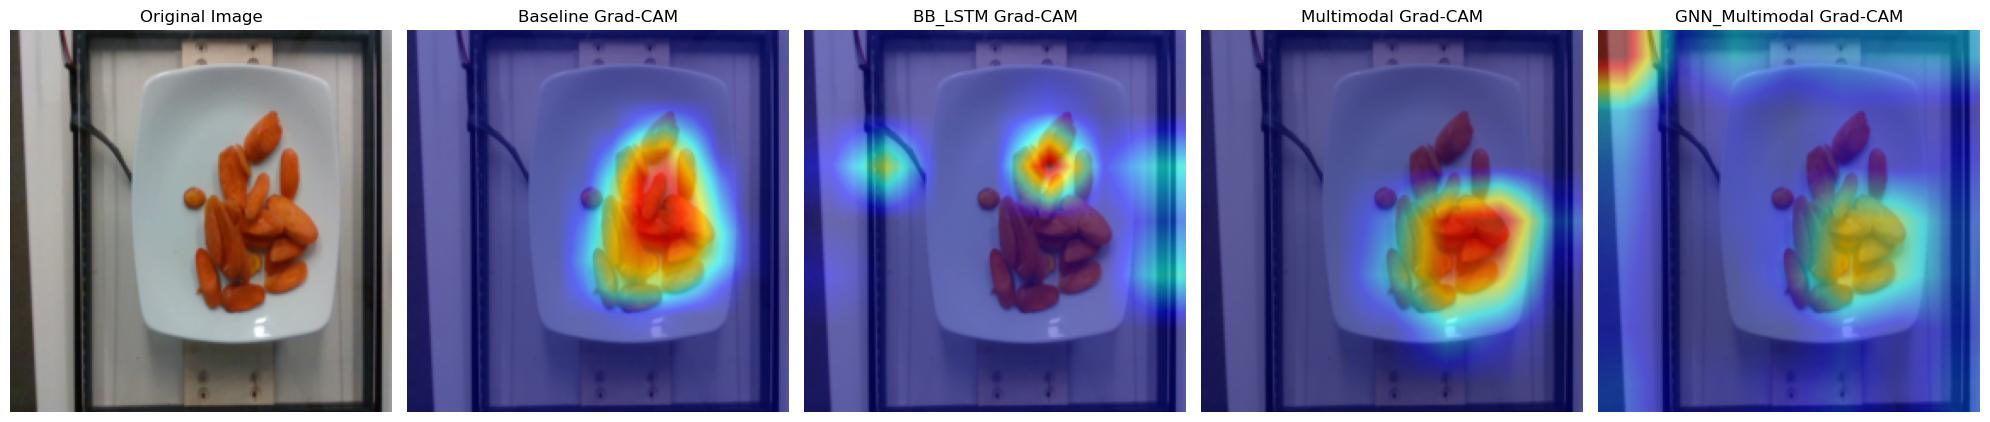

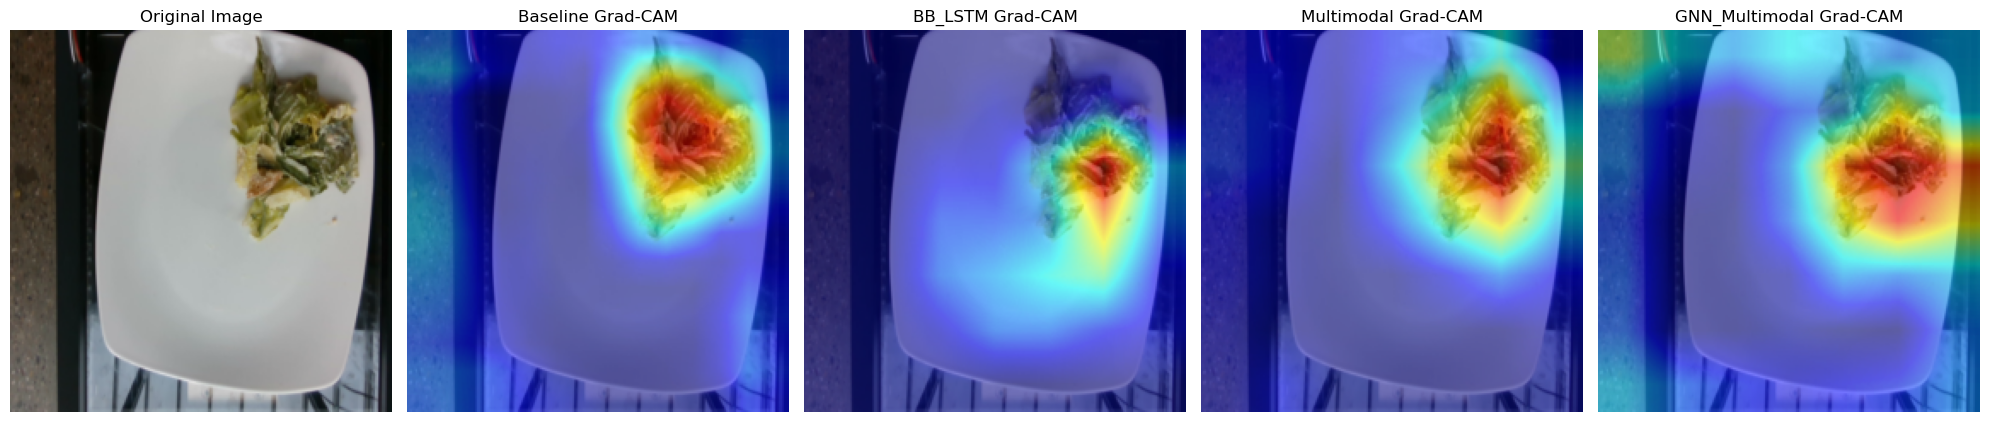

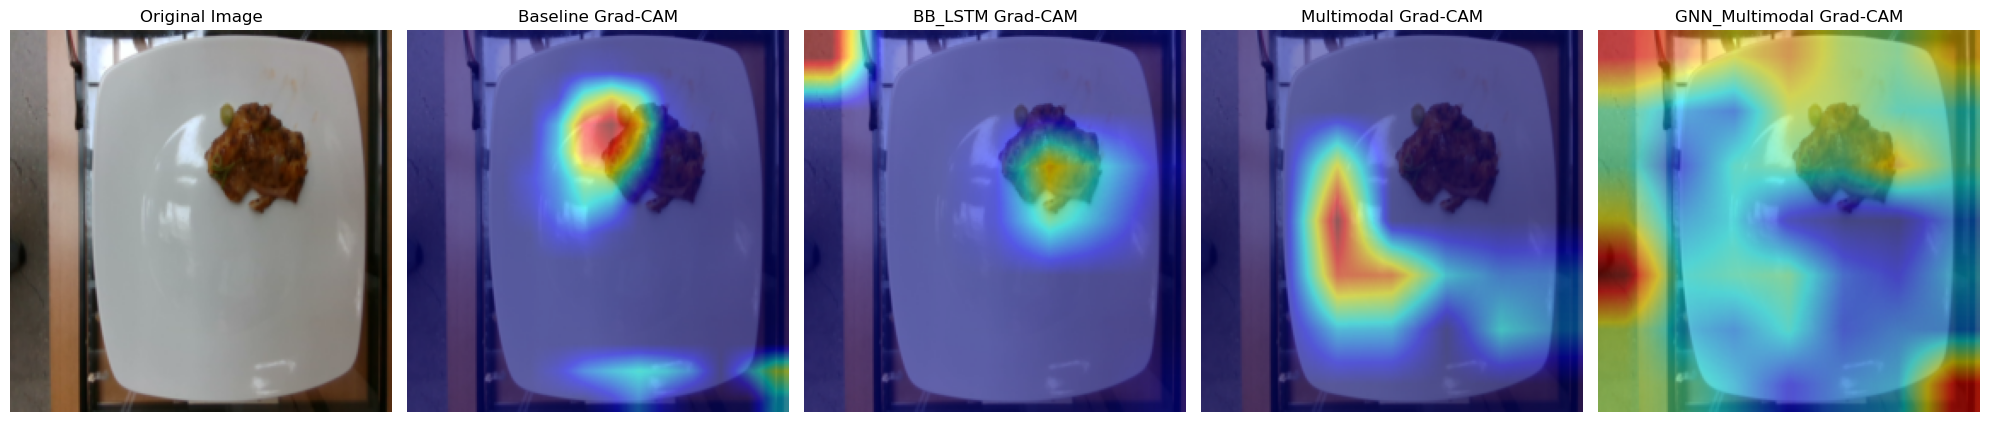

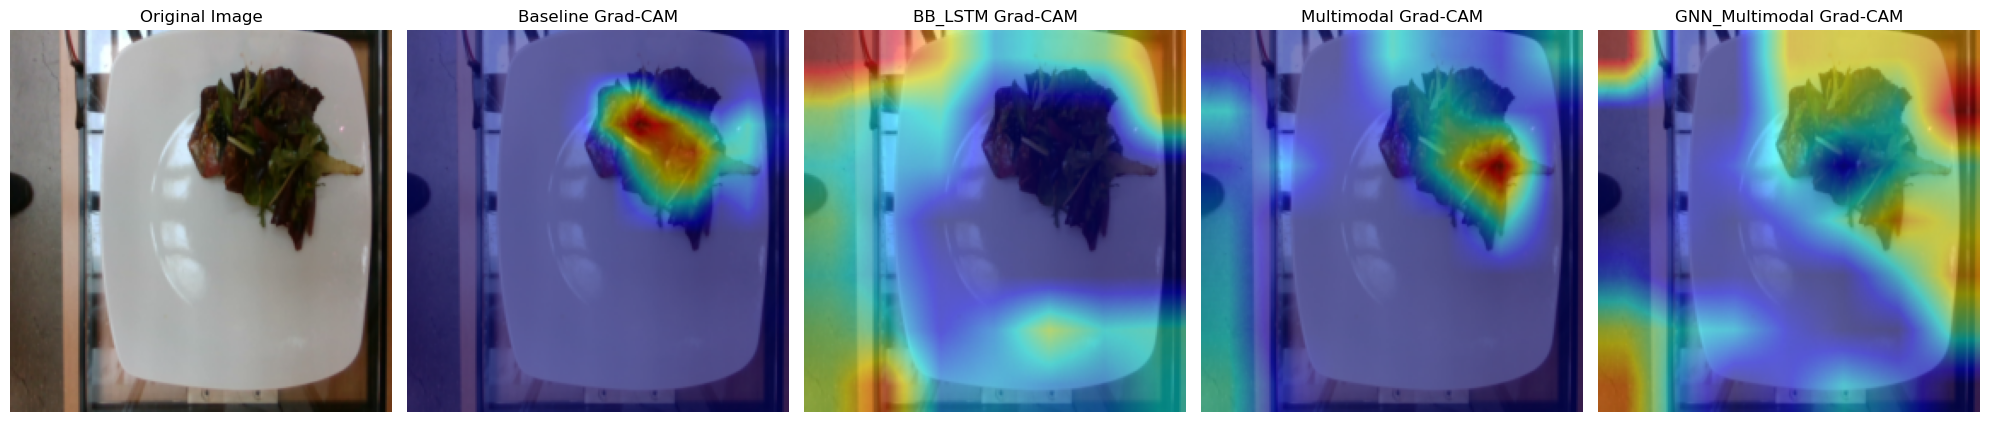

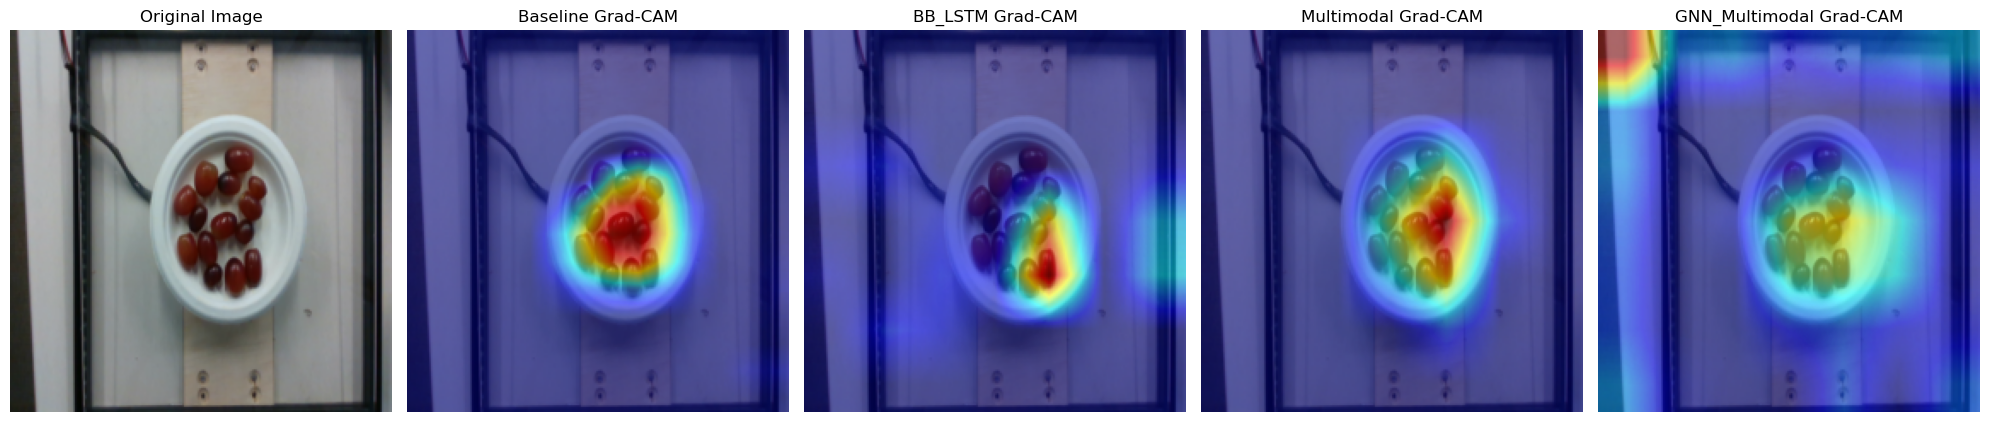

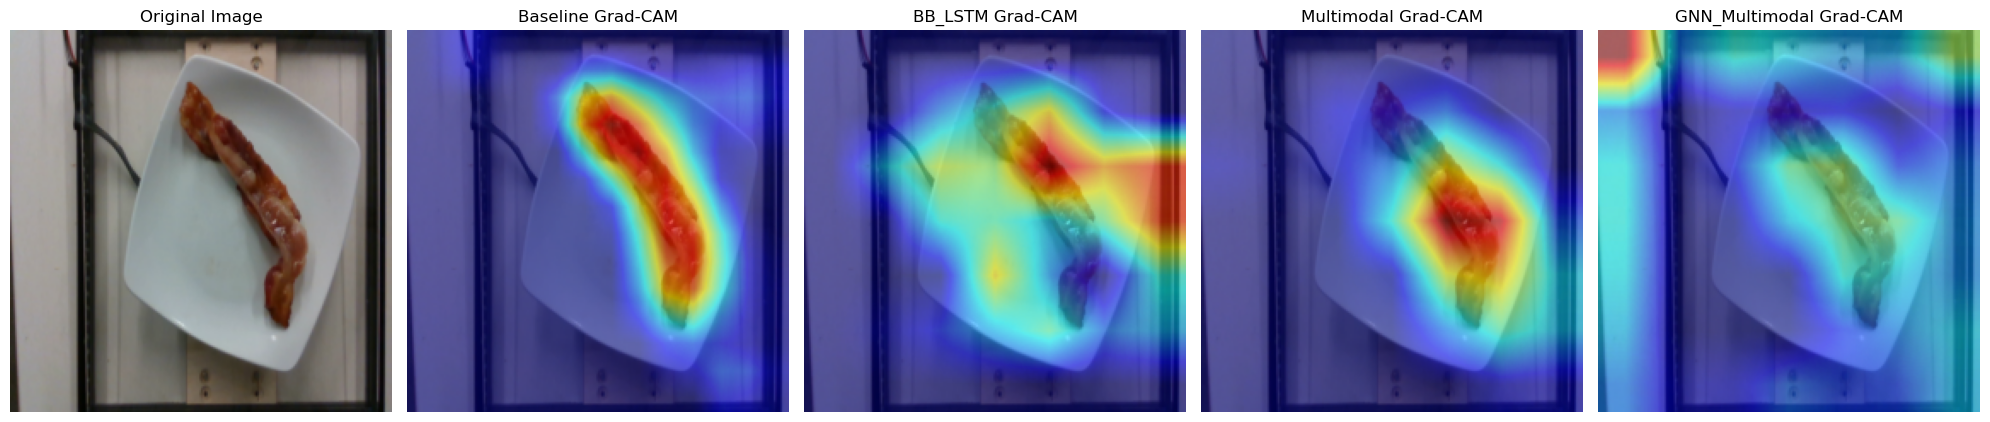

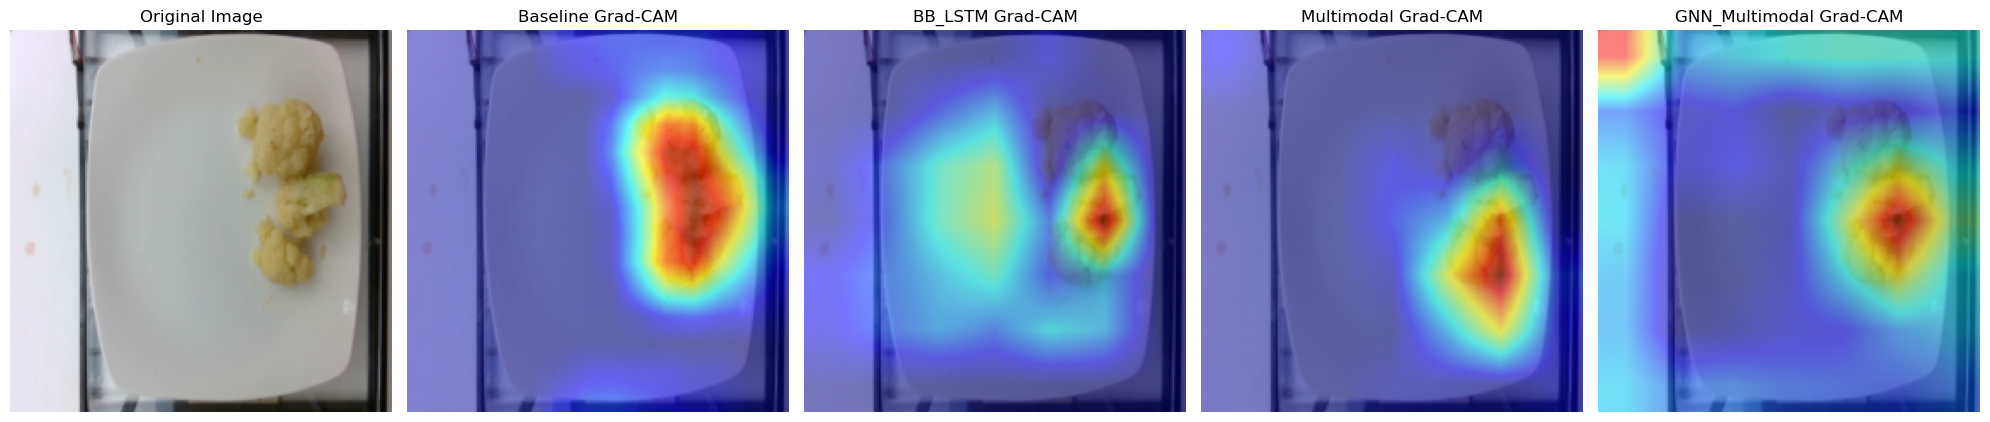

In [8]:
for (transformed_image, input_image, ingr_indx, highest_ingr_name) in zip(transformed_images, input_images, ingr_index, highest_ingr_name):
    # Compute Grad-CAM heatmap for the target ingredient (ingr_indx)
    targets = [ClassifierOutputTarget(ingr_indx)]
    
    # Grad-CAM for baseline model
    baseline_grayscale_cam = baseline_cam(input_tensor=input_image.unsqueeze(0).to(device), targets=targets)
    baseline_grayscale_cam = baseline_grayscale_cam[0, :]
    
    # Grad-CAM for bb_lstm model
    bb_lstm_grayscale_cam = bb_lstm_cam(input_tensor=input_image.unsqueeze(0).to(device), targets=targets)
    bb_lstm_grayscale_cam = bb_lstm_grayscale_cam[0, :]
    
    # Grad-CAM for multimodal model
    multimodal_grayscale_cam = multimodal_cam(input_tensor=input_image.unsqueeze(0).to(device), targets=targets)
    multimodal_grayscale_cam = multimodal_grayscale_cam[0, :]
    
    # Grad-CAM for multimodal model with GNN embeddings
    gnn_multimodal_grayscale_cam = gnn_multimodal_cam(input_tensor=input_image.unsqueeze(0).to(device), targets=targets)
    gnn_multimodal_grayscale_cam = gnn_multimodal_grayscale_cam[0, :]
    
    # Convert input image to numpy array for visualization
    input_image_np = np.transpose(transformed_image.squeeze().cpu().detach().numpy(), (1,2,0))

    # Overlay Grad-CAM heatmaps
    baseline_visualization = show_cam_on_image(input_image_np, baseline_grayscale_cam, use_rgb=True)
    bb_lstm_visualization = show_cam_on_image(input_image_np, bb_lstm_grayscale_cam, use_rgb=True)
    multimodal_visualization = show_cam_on_image(input_image_np, multimodal_grayscale_cam, use_rgb=True)
    gnn_multimodal_visualization = show_cam_on_image(input_image_np, gnn_multimodal_grayscale_cam, use_rgb=True)

   # Plot the original and Grad-CAM visualizations
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    axes[0].imshow(input_image_np)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(baseline_visualization)
    axes[1].set_title('Baseline Grad-CAM')
    axes[1].axis('off')

    axes[2].imshow(bb_lstm_visualization)
    axes[2].set_title('BB_LSTM Grad-CAM')
    axes[2].axis('off')

    axes[3].imshow(multimodal_visualization)
    axes[3].set_title('Multimodal Grad-CAM')
    axes[3].axis('off')

    axes[4].imshow(gnn_multimodal_visualization)
    axes[4].set_title('GNN_Multimodal Grad-CAM')
    axes[4].axis('off')

    # Display the figure
    plt.tight_layout()
    plt.show()